### Import

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Get the data
The dataset contains all transactions occurring between 1/12/2010 and 9/12/2011. All transactions were made in a UK-based and online retail. SuperStore mainly sells unique all-occasion gifts. Many customers are wholesalers.

In [24]:
df_original = pd.read_excel('/Users/nhuyenhuynh/Downloads/Final_project_RFM/ecommerce retail.xlsx', sheet_name='ecommerce retail')
df_original.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [25]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [26]:
# Make a deep copy of the original dataset
df = df_original.copy()

### Data cleaning

#### Missing values
In the context of RFM analysis, information about what kind of products customers buy is not important. Hence, I will remove "Description" column from the dataset. A transaction without customer id is useless in the RFM analysis; thus, I drop all rows without customer id.

Besides, only successful purchase should be counted. Hence, I will drop all cancelled orders which have the "InvoiceNo" starting with the letter "C".

In [27]:
# Drop the "Description" column
df = df.drop('Description', axis='columns')

# Drop all rows without customer id
df = df[~df['CustomerID'].isnull()]

# Drop all cancelled orders
df = df[~df['InvoiceNo'].str.contains('c', case=False, na=False)]

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 397924 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397924 non-null  object        
 1   StockCode    397924 non-null  object        
 2   Quantity     397924 non-null  int64         
 3   InvoiceDate  397924 non-null  datetime64[ns]
 4   UnitPrice    397924 non-null  float64       
 5   CustomerID   397924 non-null  float64       
 6   Country      397924 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 24.3+ MB


#### Duplicates
Normally, customers buy more than one type of products in a transaction. Thus, I assume that the combination of invoice number ("InvoiceNo") and product code ("StockCode") is the primary key. In this context, duplicates are defined as rows with the same combination of 'InvoiceNo' and 'StockCode'.

In [29]:
# Remove duplicates with the same combination of 'InvoiceNo' and 'StockCode'
df_no_duplicates = df.drop_duplicates(subset=['InvoiceNo', 'StockCode'])

# See the changes after removing duplicates
df_no_duplicates.info()

<class 'pandas.core.frame.DataFrame'>
Index: 387875 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    387875 non-null  object        
 1   StockCode    387875 non-null  object        
 2   Quantity     387875 non-null  int64         
 3   InvoiceDate  387875 non-null  datetime64[ns]
 4   UnitPrice    387875 non-null  float64       
 5   CustomerID   387875 non-null  float64       
 6   Country      387875 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 23.7+ MB


### Derive Recency-Frequency-Monetary values for each customer
- Recency (R) measures the time since the last purchase or interaction. A smaller value indicates higher engagement while a higher value indicates lower engagement from the customer.
- Frequency (F) measures how often a customer makes a purchase or interacts with a business within a specific period.
- Monetary (M) measures how much money a customer spends during a specific period. A higher monetary value indicates the customer has spent more and more engaged with the company and vice versa.

The purpose is to generate a dataframe containing 4 columns: CustomerID, Recency, Frequency, Monetary.

In [30]:
# Deep copy of the dataframe output after data cleaning process
df = df.copy()

In [31]:
# create the dataframe called df_rfm with the first column of MaxDate
df_rfm = df.groupby('CustomerID')['InvoiceDate'].max().to_frame()

# Create a new column containing the number of transactions each customer made
df_rfm['Frequency'] = df.groupby('CustomerID')['InvoiceNo'].nunique()

# Create the Recency column
specific_date = pd.to_datetime('2011-12-31')
df_rfm['Recency'] = (specific_date - df_rfm['InvoiceDate']).dt.days

# Create Value column
df['Price'] = df['UnitPrice']*df['Quantity']
df_rfm['Monetary'] = df.groupby('CustomerID')['Price'].sum()
df_rfm = df_rfm.reset_index()

# Finalize RFM dataframe
df_rfm = df_rfm[['CustomerID', 'Frequency', 'Recency', 'Monetary']].copy()

In [32]:
df_rfm.head()

,CustomerID,Frequency,Recency,Monetary
0,12346.0,1,346,77183.60
1,12347.0,7,23,4310.00
2,12348.0,4,96,1797.24
3,12349.0,1,39,1757.55
4,12350.0,1,331,334.40


In [33]:
df_rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4339 entries, 0 to 4338
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CustomerID  4339 non-null   float64
 1   Frequency   4339 non-null   int64  
 2   Recency     4339 non-null   int64  
 3   Monetary    4339 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 135.7 KB


#### Assign the rating for RFM values
Step 1: Check and deal with outliers

Step 2: Apply the quintile to assign rating to each criteria

##### Step 1: Check and deal with outliers

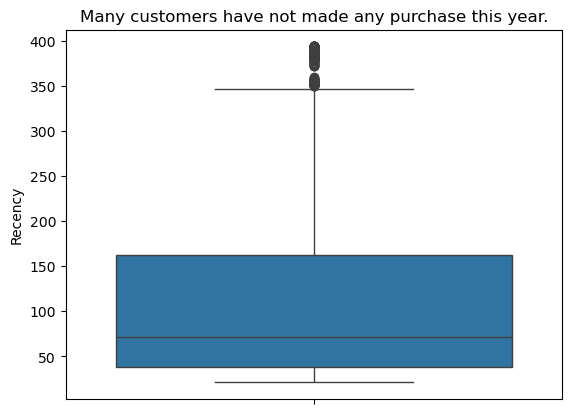

In [34]:
sns.boxplot(data= df_rfm['Recency'])
plt.title('Many customers have not made any purchase this year.')
plt.savefig('boxplot.png', dpi=300)
plt.show()

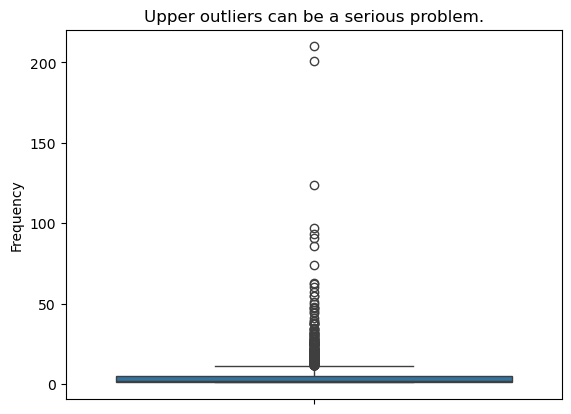

In [35]:
sns.boxplot(data= df_rfm['Frequency'])
plt.title('Upper outliers can be a serious problem.')
plt.savefig('boxplot_frequency.png', dpi=300)
plt.show()

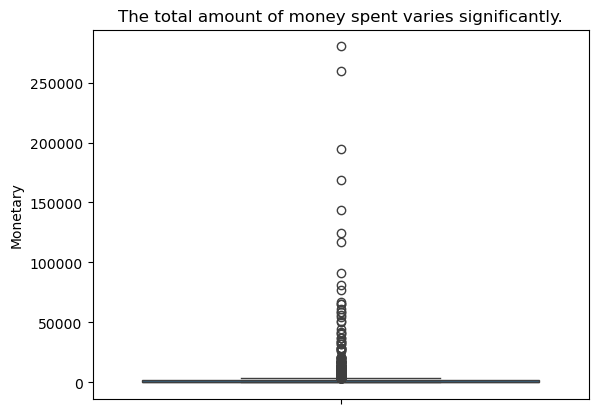

In [36]:
sns.boxplot(data= df_rfm['Monetary'])
plt.title('The total amount of money spent varies significantly.')
plt.savefig('boxplot_monetary.png', dpi=300)
plt.show()

In [37]:
# Remove customers who have not made any purchase in 2012
df_no_outliers = df_rfm[df_rfm['Recency'] > 365]


# Remove outliers based on "Frequency" criteria
Q1 = df_rfm['Frequency'].quantile(0.25)
Q3 = df_rfm['Frequency'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_no_outliers = df_rfm[(df_rfm['Frequency'] >= lower_bound) & (df_rfm['Frequency'] <= upper_bound)]


# Remove outliers based on "Monetary" criteria
Q1 = df_rfm['Monetary'].quantile(0.25)
Q3 = df_rfm['Monetary'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR
df_no_outliers = df_rfm[df_rfm['Monetary'] <= upper_bound]

df_no_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3912 entries, 2 to 4338
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CustomerID  3912 non-null   float64
 1   Frequency   3912 non-null   int64  
 2   Recency     3912 non-null   int64  
 3   Monetary    3912 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 152.8 KB


##### Step 2: Apply the quintile to generate relative RFM
Quintile statistical technique is used to divide the dataset into 5 equal parts

In [38]:
df_no_outliers['FrequencyRate'] = pd.cut(df_no_outliers["Frequency"], 5, labels=['1','2','3','4','5'], duplicates='drop')
df_no_outliers['RecencyRate'] = pd.cut(df_no_outliers['Recency'], 5, labels=['5','4','3','2','1'], duplicates='drop')
df_no_outliers['MonetaryRate'] = pd.cut(df_no_outliers['Monetary'], 5, labels=['1','2','3','4','5'], duplicates='drop')
df_no_outliers['Rate'] = df_no_outliers['FrequencyRate'].str.cat(df_no_outliers['RecencyRate']).str.cat(df_no_outliers['MonetaryRate'])
df_rate = df_no_outliers.copy()
df_rate.head()

/var/folders/14/bdzytj054fb42j0bk8nf7jrw0000gn/T/ipykernel_10639/4067550748.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_outliers['FrequencyRate'] = pd.cut(df_no_outliers["Frequency"], 5, labels=['1','2','3','4','5'], duplicates='drop')
/var/folders/14/bdzytj054fb42j0bk8nf7jrw0000gn/T/ipykernel_10639/4067550748.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_outliers['RecencyRate'] = pd.cut(df_no_outliers['Recency'], 5, labels=['5','4','3','2','1'], duplicates='drop')
/var/folders/14/

,CustomerID,Frequency,Recency,Monetary,FrequencyRate,RecencyRate,MonetaryRate,Rate
2,12348.0,4,96,1797.24,1,4,3,143
3,12349.0,1,39,1757.55,1,5,3,153
4,12350.0,1,331,334.40,1,1,1,111
5,12352.0,8,57,2506.04,1,5,4,154
6,12353.0,1,225,89.00,1,3,1,131


##### Customer segmentation

In [39]:
conditions = [(df_rate['Rate'].isin(['555', '554', '544', '545', '454', '455', '445'])),
             (df_rate['Rate'].isin(['543', '444', '435', '355', '354', '345', '344', '335'])),
             (df_rate['Rate'].isin(['553', '551', '552', '541', '542', '533', '532', '531', '452', '451', '442', '441', '431', '453', '433', '432', '423', '353', '352', '351', '342', '341', '333', '323'])),
             (df_rate['Rate'].isin(['512', '511', '422', '421', '412', '411', '311'])),
              (df_rate['Rate'].isin(['525', '524', '523', '522', '521', '515', '514', '513', '425','424', '413','414','415', '315', '314', '313'])),
              (df_rate['Rate'].isin(['535', '534', '443', '434', '343', '334', '325', '324'])),
              (df_rate['Rate'].isin(['331', '321', '312', '221', '213', '231', '241', '251'])),
              (df_rate['Rate'].isin(['255', '254', '245', '244', '253', '252', '243', '242', '235', '234', '225', '224', '153', '152', '145', '143', '142', '135', '134', '133', '125', '124'])),
              (df_rate['Rate'].isin(['155', '154', '144', '214','215','115', '114', '113'])),
              (df_rate['Rate'].isin(['332', '322', '233', '232', '223', '222', '132', '123', '122', '212', '211'])),
              (df_rate['Rate'].isin(['111', '112', '121', '131','141','151']))
        ]

choices = ['Champions','Loyal','Potential Loyalist','New Customers','Promising','Need Attention',
           'About To Sleep','At Risk','Cannot Lose Them', 'Hibernating customers','Lost customers']

df_rate['Segment'] = np.select(conditions, choices)
df_rate = df_rate.reset_index(drop=True)
df_rate.head()

,CustomerID,Frequency,Recency,Monetary,FrequencyRate,RecencyRate,MonetaryRate,Rate,Segment
0,12348.0,4,96,1797.24,1,4,3,143,At Risk
1,12349.0,1,39,1757.55,1,5,3,153,At Risk
2,12350.0,1,331,334.40,1,1,1,111,Lost customers
3,12352.0,8,57,2506.04,1,5,4,154,Cannot Lose Them
4,12353.0,1,225,89.00,1,3,1,131,Lost customers


### Visualization and Insights

In [44]:
df_rate['Segment'].value_counts()/len(df_rate['CustomerID'])*100

Segment
Lost customers           59.176892
At Risk                  31.467280
Cannot Lose Them          6.543967
Hibernating customers     2.581800
Loyal                     0.153374
Potential Loyalist        0.076687
Name: count, dtype: float64

/var/folders/14/bdzytj054fb42j0bk8nf7jrw0000gn/T/ipykernel_10639/1637180513.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  visual1.set_xticklabels(visual1.get_xticklabels(), rotation=60)


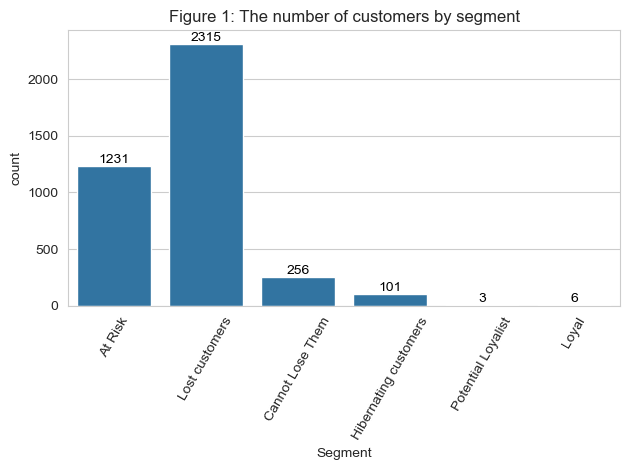

In [45]:
# Visualize the number of customers by segment
sns.set_style('whitegrid')
visual1 = sns.countplot(data=df_rate, x='Segment')
visual1.set_xticklabels(visual1.get_xticklabels(), rotation=60)
visual1.bar_label(visual1.containers[0], fontsize=10, color='black')
visual1.set_title("Figure 1: The number of customers by segment")
plt.tight_layout()
plt.savefig('figure1.png', dpi=300)
plt.show()

/var/folders/14/bdzytj054fb42j0bk8nf7jrw0000gn/T/ipykernel_10639/528601560.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


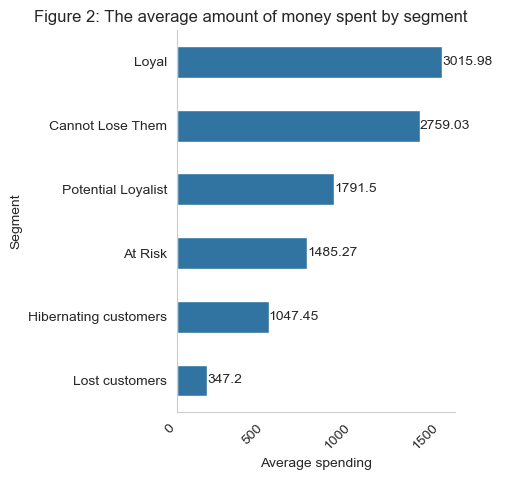

In [75]:
df_rate_sorted = df_rate.groupby('Segment')['Monetary'].mean().sort_values(ascending=False).reset_index()
g = sns.catplot(x='Monetary', y='Segment', data=df_rate_sorted, kind='bar', width=0.5)
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
g.fig.suptitle('Figure 2: The average amount of money spent by segment', y=0.95)
ax.set_xlabel('Average spending', fontsize=10)
ax.set_ylabel('Segment', fontsize=10)
ax.bar_label(ax.containers[0])
plt.grid(False)
plt.tight_layout()
plt.savefig('figure2.png', dpi=300)
plt.show()

/var/folders/14/bdzytj054fb42j0bk8nf7jrw0000gn/T/ipykernel_10639/921518966.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


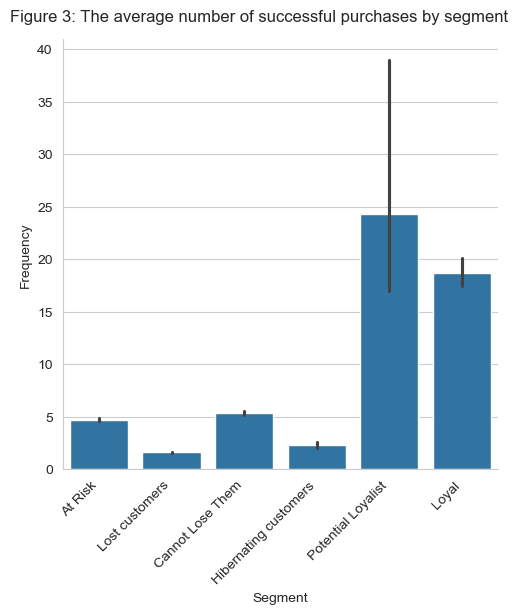

In [76]:
g = sns.catplot(x='Segment', y='Frequency', data=df_rate, kind='bar', width=0.5)
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
g.fig.suptitle('Figure 3: The average number of successful purchases by segment', y=1.03)
plt.show()

/var/folders/14/bdzytj054fb42j0bk8nf7jrw0000gn/T/ipykernel_10639/3384419956.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), ha='right')


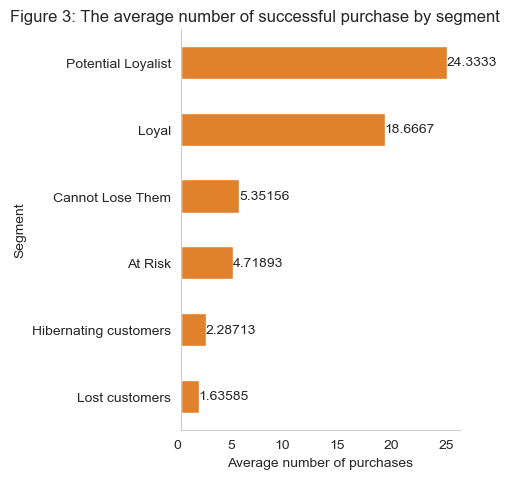

In [82]:
df_rate_sorted = df_rate.groupby('Segment')['Frequency'].mean().sort_values(ascending=False).reset_index()
g = sns.catplot(x='Frequency', y='Segment', data=df_rate_sorted, kind='bar', width=0.5, color='#FF7F0E')
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), ha='right')
g.fig.suptitle('Figure 3: The average number of successful purchase by segment', y=0.95)
ax.set_xlabel('Average number of purchases', fontsize=10)
ax.set_ylabel('Segment', fontsize=10)
ax.bar_label(ax.containers[0])
plt.grid(False)
plt.tight_layout()
plt.savefig('figure3.png', dpi=300)
plt.show()

/var/folders/14/bdzytj054fb42j0bk8nf7jrw0000gn/T/ipykernel_10639/3591380793.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), ha='right')


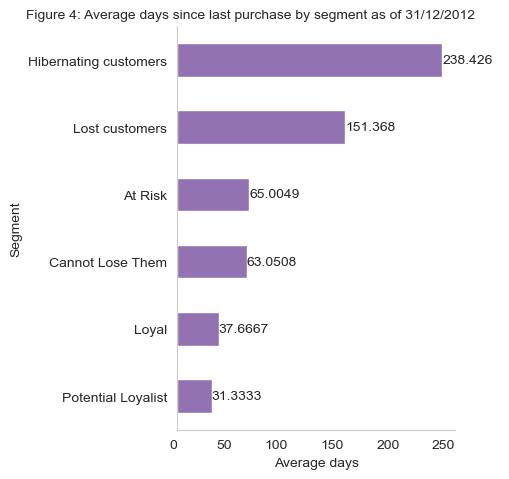

In [89]:
df_rate_sorted = df_rate.groupby('Segment')['Recency'].mean().sort_values(ascending=False).reset_index()
g = sns.catplot(x='Recency', y='Segment', data=df_rate_sorted, kind='bar', width=0.5, color='#9467BD')
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), ha='right')
g.fig.suptitle('Figure 4: Average days since last purchase by segment as of 31/12/2012', fontsize=10, y=0.95)
ax.set_xlabel('Average days', fontsize=10)
ax.set_ylabel('Segment', fontsize=10)
ax.bar_label(ax.containers[0])
plt.grid(False)
plt.tight_layout()
plt.savefig('figure4.png', dpi=300)
plt.show()

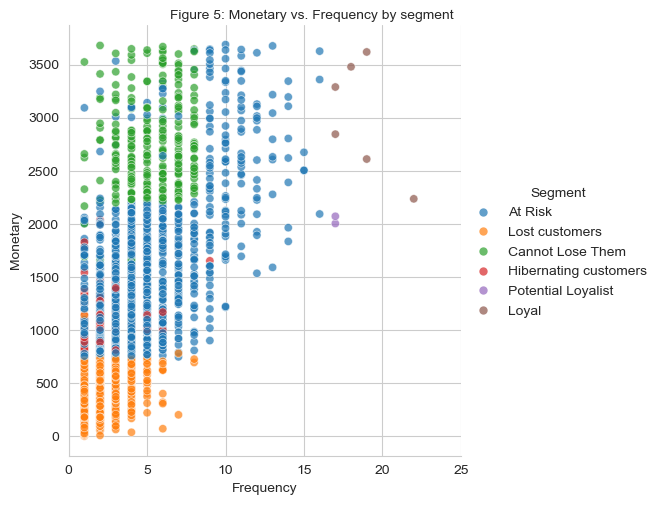

In [100]:
g = sns.relplot(x='Frequency', y='Monetary', data=df_rate, kind='scatter', hue="Segment", alpha=0.7)
g.fig.suptitle("Figure 5: Monetary vs. Frequency by segment", fontsize=10, y=1)
plt.xlim(0, 25)
plt.savefig('figure5.png', dpi=300)
plt.show()

### Recommendations